This notebook shows how to use [GEMDAT](https://gemdat.readthedocs.org) to compute information related to molecular orientations and rotations.

First, it computes the bonds between central and satellite atoms, following the user's instructions. Then it computes their trajectory in cartesian, spherical and conventional form. If a symmetry group is defined, the statistics can be enhanced by exploiting the symmetry. Now the user can compute and plot the relevant information.

As input you will need:

1. [trajectory](https://pymatgen.org/pymatgen.symmetry.html#pymatgen.symmetry.analyzer.SpacegroupAnalyzer)
2. Orientational indication including:
    - central atom species
    - satellite atom species
    - number of expected neighbors
3. Optionally, the symmetry group 


The resulting orientation information can be visualized on a rectilinear plot, while the user can also access the statistics of the bond length. Finally, it is possible to plot the autocorrelation obtaining information about expected time for rotations. 

In [1]:
from __future__ import annotations

import random
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import time

from gemdat import Trajectory, plots
import gemdat.rotations as gr

In [2]:
# Fix the seed for reproducibility
random.seed(42)
np.random.seed(42)

In [3]:
# Select the trajectory to load
start_time = time.time()
traj = Trajectory.from_vasprun(Path('../GEMDAT/tests/data/short_simulation/vasprun_rotations.xml'))
end_time = time.time()
elapsed_time = end_time - start_time
print(f'Loaded .xml in  {elapsed_time} seconds')

Loaded .xml in  0.1940135955810547 seconds


In [4]:
# Take only the last time slice of the trajectory to speed up the calculations
traj = traj.split(n_parts=12, equal_parts=True)[1]

In [5]:
# Extract the trajectories of the unit vectors
central_atoms = 'S'
satellite_atoms = 'O'
n_expected_neigh = 8
bd = gr.Orientations(traj, central_atoms, satellite_atoms, n_expected_neigh)

In [6]:
# You can get the unit vectors in direct coordinates
normalized_direct_cart = bd.get_unit_vectors_traj(normalize=False)
# or in the conventional coordinates
direct_cart = bd.get_conventional_form(normalize=False)

In [7]:
# Define the symmetry group
sg = gr.Oh_point_group()
# The user can access its representation
sym_ops_Oh = sg.sym_ops_Oh
# in the example of the Oh point group, there are 48 symmetry operations, so 48 matrices of 3x3
print(sym_ops_Oh.shape)

(3, 3, 48)


In [8]:
# Convert conventional form trajectory in spherical coordinates
direction_spherical = bd.cartesian_to_spherical(direct_cart=direct_cart, degrees=True)

In [9]:
# Symmetrize the trajectory
# Notice that the user can pass any symmetry operations, not only the Oh point group
direction_cart_sym =  bd.get_symmetric_traj(sym_ops_Oh)
direction_spherical_sym = bd.cartesian_to_spherical(direct_cart=direction_cart_sym, degrees=True)

Compute the rectilinear plots: 2d maps of the azimutal and elevation angles.
Here we also show the effect of the symmetrization and data normalization.

/tmp/ipykernel_168858/112050151.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig4.show()


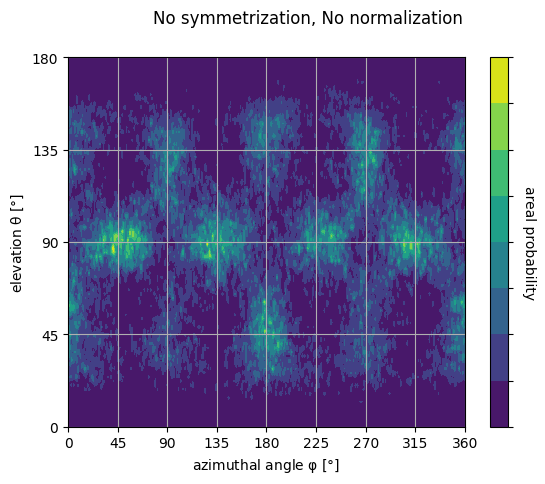

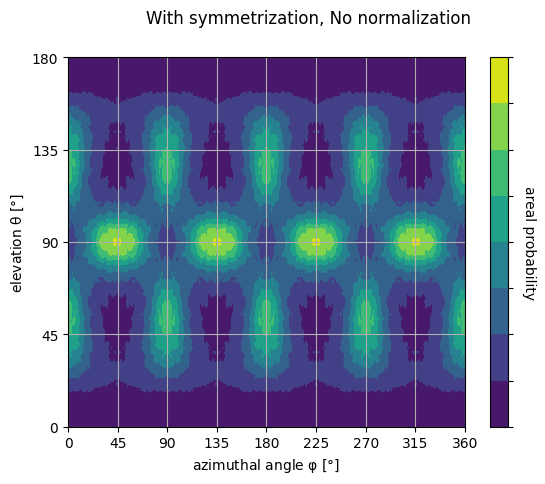

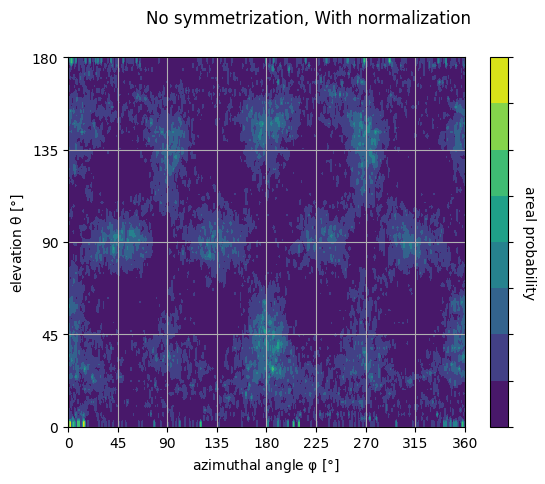

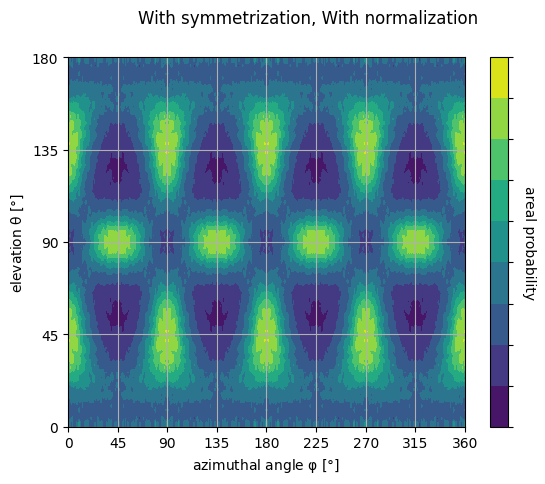

In [10]:
# (1) No normalization and no symmetrization
fig1 = plots.rectilinear_plot(trajectory=direction_spherical, normalize=False)
fig1.suptitle('No symmetrization, No normalization')

# (2) No normalization and with symmetrization
fig2 = plots.rectilinear_plot(trajectory=direction_spherical_sym, normalize=False)
fig2.suptitle('With symmetrization, No normalization')

# (3) With normalization and no symmetrization
fig3 = plots.rectilinear_plot(trajectory=direction_spherical)
fig3.suptitle('No symmetrization, With normalization')

# (4) With normalization and with symmetrization
fig4 = plots.rectilinear_plot(trajectory=direction_spherical_sym)
fig4.suptitle('With symmetrization, With normalization')
fig4.show()

Plot the bond length distribution. A skewed gaussian is automatically fitted to the data in order to provide useful information.

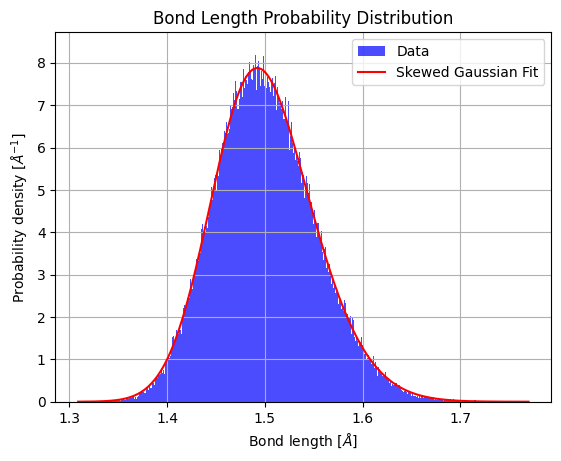

In [11]:
fig1 = plots.bond_length_distribution(direction=direction_spherical_sym, bins=1000)

Now we compute and plot the autocorrelation of the unit vectors:

/tmp/ipykernel_168858/4135361211.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig1.show()


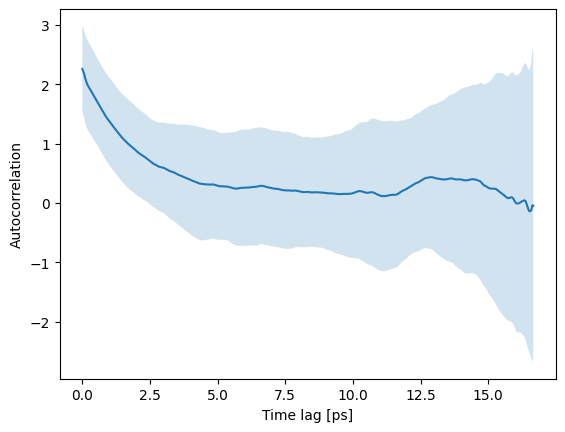

In [12]:
fig1 = plots.unit_vector_autocorrelation(trajectory=normalized_direct_cart, time_units=traj.time_step)
fig1.show()

In [13]:
# Notice that the user can also calculate the autocorrelation function as follows
from gemdat.rotations import autocorrelation
autocorrelation, std = autocorrelation(normalized_direct_cart)

In this notebook, we want to compare the autocorrelation implemented in `GEMDAT` using FFT, with a direct implementation that was developed for a previous matlab code. For this reason we define in the next block the matlab functions that we want to compare:

In [14]:
def simple_autocorr(direct_cart, Npt=100):
    start_time = time.time()
    Nts = len(normalized_direct_cart)  # number timesteps
    ep = Nts - 1
    dts = np.round(np.logspace(1, np.log10(ep), Npt)).astype(int)
    mean_autocorr = np.zeros(len(dts))
    for k, dt in enumerate(dts):
        autocorr = np.sum(normalized_direct_cart[:-dt] *
                          normalized_direct_cart[dt:],
                          axis=-1)
        mean_autocorr[k] = np.mean(autocorr)
    end_time = time.time()
    elapsed_time = end_time - start_time
    return dts * 0.002, mean_autocorr  #time in ps

from concurrent.futures import ThreadPoolExecutor
def autocorr_par(direct_cart, Npt=100):
    def compute_autocorr(dt):
        autocorr = np.sum(direct_cart[:-dt] * direct_cart[dt:], axis=-1)
        mean_autocorr = np.mean(autocorr)
        std_autocorr = np.std(autocorr)
        return mean_autocorr, std_autocorr
    Nts = len(direct_cart)
    ep = Nts - 1
    dts = np.round(np.logspace(1, np.log10(ep), Npt)).astype(int)
    mean_autocorr = np.zeros(len(dts))
    std_autocorr = np.zeros(len(dts))
    with ThreadPoolExecutor() as executor:
        results = list(executor.map(compute_autocorr, dts))
    for i, (mean, std) in enumerate(results):
        mean_autocorr[i] = mean
        std_autocorr[i] = std
    return dts * 0.002, mean_autocorr, std_autocorr

And we compare `gemdat.unit_vector_autocorrelation` with the matlab implementation

/tmp/ipykernel_168858/899886916.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig1.show()


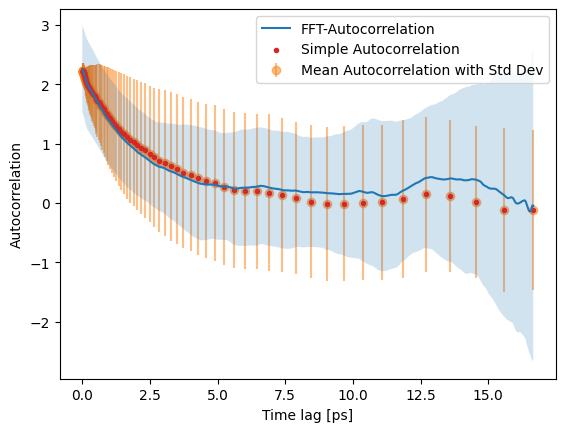

In [16]:
fig1 = plots.unit_vector_autocorrelation(trajectory=normalized_direct_cart, time_units=traj.time_step)
ax1 = plt.gca()
x, y = simple_autocorr(normalized_direct_cart)
ax1.scatter(x, y, marker='.', color='tab:red', label='Simple Autocorrelation')
x, y, y_std = autocorr_par(normalized_direct_cart)
ax1.errorbar(x,
             y,
             zorder=-1,
             yerr=y_std,
             fmt='o',
             alpha=0.5,
             label='Mean Autocorrelation with Std Dev')
ax1.legend()
fig1.show()